In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
flight_data = pd.read_csv('Clean_Dataset.csv')
flight_data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [26]:
flight_data.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [27]:
flight_data.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [28]:
flight_data.columns

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [29]:
flight_data['flight'].nunique()

1561

In [30]:
flight_data.drop(['Unnamed: 0', 'flight'], axis = 1, inplace = True)

In [31]:
#Splitting categorical and numerical columns for EDA and for preprocessing
numeric = flight_data.select_dtypes([np.number])
categorical = flight_data.drop(['duration', 'days_left', 'price'], axis = 1)

## EDA

In [32]:
#function to draw histograms for each column
def draw_hist(df):
    for i in df.columns:
        sns.histplot(data = df[i])
        plt.show()

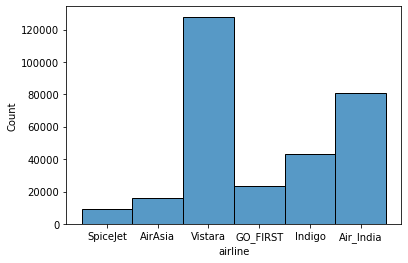

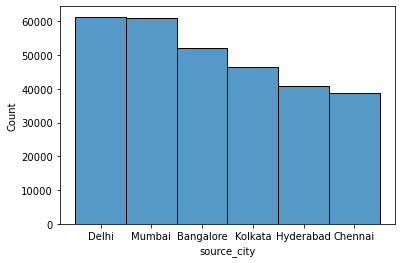

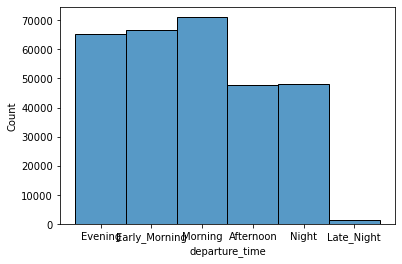

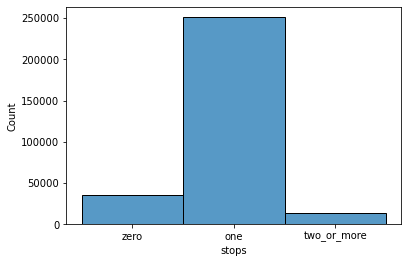

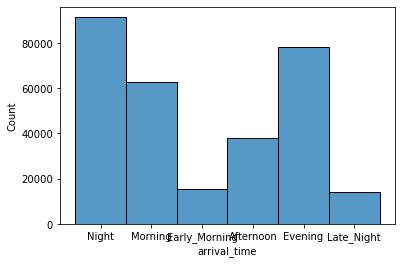

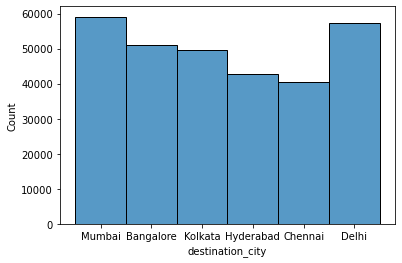

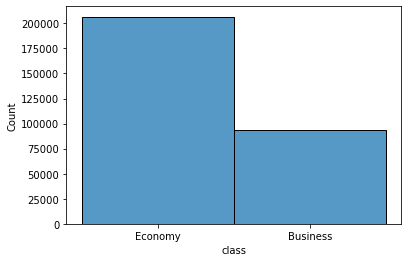

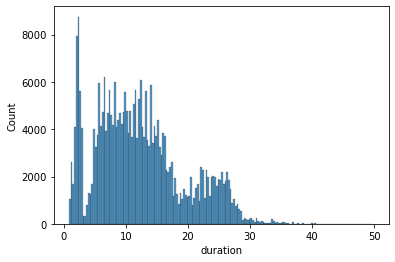

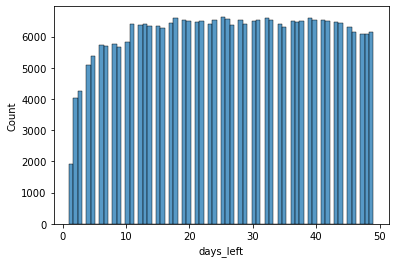

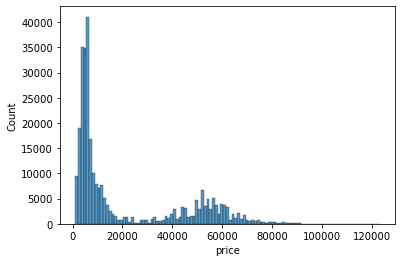

In [33]:
draw_hist(flight_data)

In [ ]:
#countplots

In [ ]:
#Note: why histogram of days_left have gap?

Just by examining the column names, here are some categorical features I wanted to investigate as they related to price

In [56]:
hue_list = ['airline', 'departure_time', 'stops', 'class']

In [65]:
def draw_hue_hist(df, feature_list):
    for i in feature_list:
        sns.histplot(x = df['price'], hue = df[i], bins = 20)
        plt.show()

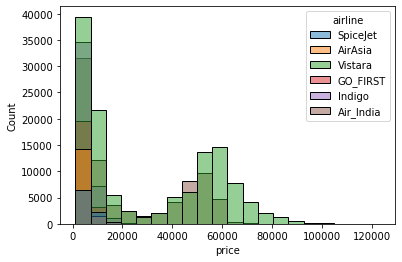

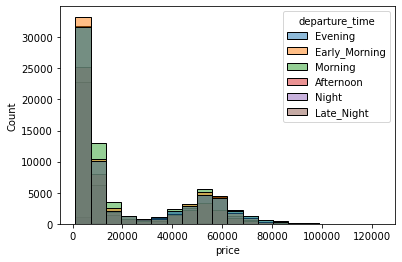

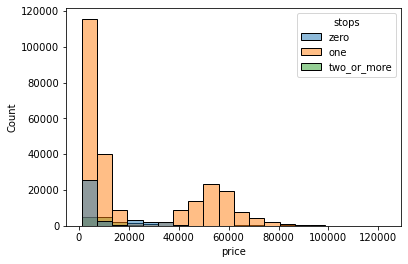

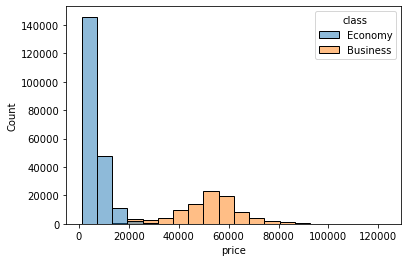

In [66]:
draw_hue_hist(flight_data, hue_list)

airline and departure_time have a lot of unique categories, so it is hard to see the differences in the distributions of those categories. We can try looking at the median price grouped by departure_time and airline separately. 

In [78]:
flight_data.groupby('airline').median()

,duration,days_left,price
airline,,,
AirAsia,9.33,28.0,3276.0
Air_India,15.00,26.0,11520.0
GO_FIRST,8.83,27.0,5336.0
Indigo,6.00,27.0,4453.0
SpiceJet,12.00,23.0,5654.0
Vistara,12.50,26.0,15543.0


In [79]:
flight_data.groupby('departure_time').median()

,duration,days_left,price
departure_time,,,
Afternoon,8.170,26.0,6663.0
Early_Morning,11.580,26.0,7212.0
Evening,14.500,26.0,7425.0
Late_Night,6.625,29.0,4499.0
Morning,10.000,26.0,8112.0
Night,13.420,26.0,7813.0


There are also some numerical features I wanted to explore

In [68]:
numeric_scatter_list = ['duration', 'days_left']

In [69]:
def draw_scatter(df, scatter_list):
    for i in scatter_list:
        sns.scatterplot(x = df[i], y = df['price'])
        plt.show()

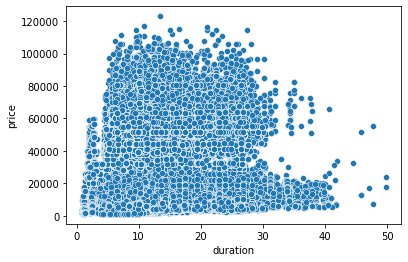

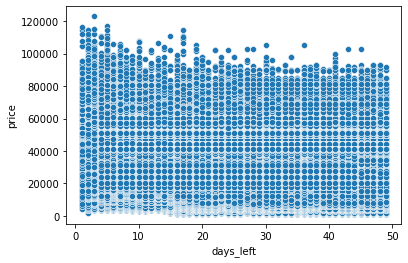

In [70]:
draw_scatter(flight_data, numeric_scatter_list)

In [ ]:
#Can't make out much from the graphs

Correlations

In [80]:
def corr_matrix(df):
    fig, ax = plt.subplots(figsize = (10, 10))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

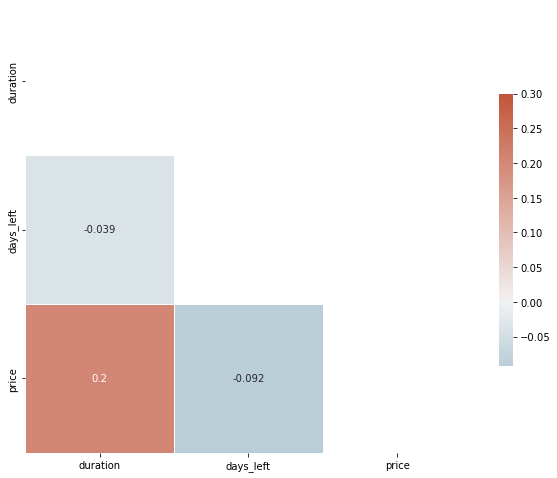

In [81]:
corr_matrix(flight_data)